In [ ]:
import numpy as np
from scipy.sparse import diags, kron, csr_matrix, csc_matrix
from scipy.sparse.linalg import spsolve, norm, inv, eigsh
import pandas as pd
# Librerias graficas
import matplotlib.pyplot as plt
from matplotlib import animation # animaciones
from matplotlib.gridspec import GridSpec
from matplotlib import rc
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sb
rc('text', usetex=False) # para usar latex en matplotlib
# Estilo de las figuras
sb.set_theme(style="darkgrid")
sb.set_palette('tab10')

*Universidad de Chile*  
*Facultad de Ciencias Físicas y Matemáticas*  
*Departamento de Ingeniería Matemática*

**MA5307-1 Análisis Numérico de EDP: Teoría y Laboratorio**  
**Profesor:** Axel Osses  
**Auxiliares:** Emir Chacra  
**Integrantes:** Axel Alvarez, Axel Kolm, Manuel Torres (grupo: Los Axels falsos)

# Laboratorio 3

El objetivo de este laboratorio es entender e implementar un esquema numérico basado en elementos finitos de Lagrange para una ecuacion elíptica de segundo orden en una dimensión con condiciones de frontera Dirichlet.

Sean $\alpha,\beta,u_{\alpha},u_{\beta}\in\mathbb{R}$, $\varepsilon>0$,
$\Omega=\left(  \alpha,\beta\right)  $, $a\in W^{1,\infty}\left(
\Omega\right)  $, $b\in L^{\infty}\left(  \Omega\right)  $ y $f\in
L^{2}\left(  \Omega\right)  $. 

Considere la siguiente ecuación de difusión-advección-reacción dada por
$\begin{align}
-\varepsilon u^{\prime\prime}+au^{\prime}+bu  &  =f\qquad\text{sobre }%
\Omega\nonumber\\
u\left(  \alpha\right)   &  =u_{\alpha}\tag{P}\\
u\left(  \beta\right)   &  =u_{\beta}\nonumber
\end{align}$

### **Ejercicio 1:**

Programe una funcion que resuelva numéricamente el problema (P) usando el metodo descrito. Las entradas del programa deben ser la discretización $\{x_j\}^{N+1}_{j=0}$ como un vector ordenado, $u_\alpha$,$u_\beta$, $\varepsilon$, $a$, $b$ y $f$. 

La salida de este programa debe ser un vector del mismo tamaño que la discretización con las soluciones discretas del esquema.

In [ ]:
def Resuelve(x,ualpha,ubeta,eps,a,b,f):
    # Definiciones preliminares
    N   = x.shape[0]-2
    h   = x[1:] - x[:-1]
    x_b = (x[1:] + x[:-1])*(1/2)
    "Offset "
    offset  = [-1, 0, 1]
    "Matrices A_j para j=0,...,N"
    # Crear diagonales
    diag_0 = np.array([1]*2 + [0]*N)
    diag_1 = np.array([-1] + [0]*N)
    # Crear una lista con las matrices A_j
    A_list = [diags(np.array([np.roll((1/h[j])*diag_1,j),
                              np.roll((1/h[j])*diag_0,j),
                              np.roll((1/h[j])*diag_1,j)], 
                             dtype= object),offset) for j in range(N+1)]
    "Matrices B_j para j=0,...,N"
    # Crear diagonales
    diag_2 = np.array([-1*0.5] + [0]*N)
    diag_3 = np.array([-1*0.5,1*0.5] + [0]*N)
    diag_4 = np.array([1*0.5] + [0]*N)
    # Crear una lista con las matrices B_j
    B_list = [diags(np.array([np.roll(diag_2,j),
                              np.roll(diag_3,j),
                              np.roll(diag_4,j)], 
                             dtype= object),offset) for j in range(N+1)]
    "Matrices C_j para j=0,...,N"
    # Crear diagonales
    diag_5 = np.array([1/3]*2 + [0]*N)
    diag_6 = np.array([1/6] + [0]*N)
    # Crear una lista con las matrices C_{j}
    C_list = [diags(np.array([np.roll(diag_6,j),
                              np.roll(diag_5,j),
                              np.roll(diag_6,j)], 
                             dtype= object),offset) for j in range(N+1)]
    "A_h es la suma de las matrices"
    A_h = A_list[0] + B_list[0] + C_list[0]
    for i in range(1,N+1):
        A_h += eps*A_list[i] + a*B_list[i] + b*C_list[i]
    "Funciones f_j y f_h"
    # crear f_j vector de largo N+2, j: 0,..,N
    f_list = [np.roll(np.array(
        [h[j]*(1/6)*(f(x[j])+2*f(x_b[j])), 
         h[j]*(1/6)*(2*f(x_b[j])+f(x[j+1]))]+[0]*N),j) for j in range(N+1)]
    # Crear f_h
    f_h = f_list[0]
    for i in range(1,N+1):
        f_h += f_list[i]
    output = 0
    "A_h* y f_h* con puntos interiores"
    A_h_int = A_h[1:N+1,1:N+1] 
    f_h_int = f_h[1:N+1]
    w = spsolve(A_h_int, f_h_int-np.roll(np.array([A_h[N,N+1]*ubeta,
                                          A_h[1,0]*ualpha]+ [0]*(N-2)), -1))
    u = np.array([ualpha]+list(w)+[ubeta])
    return u

### **Ejercicio 2:** 
Considere $f\equiv1$, $a=1$, $b=0$ y $\Omega=\left(  0,1\right)  $.

Para $u_{\alpha}=u_{\beta}=0$, la solución analítica de $\textbf{(P)}$ es única e igual a la
función
$$
u(x)=x-\dfrac
{\exp\left(  \frac{x-1}{\varepsilon}\right)  -\exp\left(  -\frac
{1}{\varepsilon}\right)  }{1-\exp\left(  -\frac{1}{\varepsilon}\right)}\hspace{1cm} \forall x\in\left[  0,1\right] 
$$

a. Para una discretización uniforme con $N \in \{5, 10, 20\}$ elementos (es decir, $h_j = h = \frac{1}{N+1}$), calcule la solución numérica cuando $\varepsilon = 1$. Grafique todas las soluciones numéricas y la solución analítica (esta última discretizada en una gran cantidad de puntos equiespaciados) en una misma gráfica. Comente sus observaciones.

In [ ]:
#Parametros
f       = lambda x:1
a       = 1
b       = 0
ualpha  = 0
ubeta   = 0

In [ ]:
def solucion(x,epsilon):
    """
    -Input:
    -Output:
    -Descripcion:
    """
    output = x-(np.e**((x-1)/epsilon)-np.e**(-1/epsilon))/(1-np.e**(-1/epsilon))
    return output 

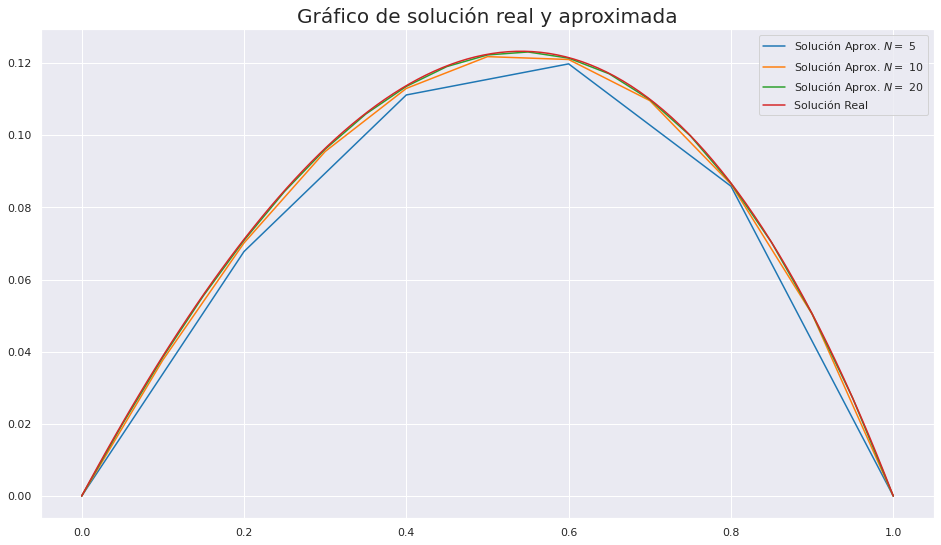

In [ ]:
N_lista = [5, 10, 20]
epsilon = 1
x_2     = np.linspace(0,1,100)
# Plotear para cada N en el arreglo N_lista
plt.figure(figsize = (16,9))
plt.grid(True)
for N in N_lista:
    x = np.linspace(0,1,N+1)
    plt.plot(x, Resuelve(x,ualpha,ubeta,epsilon,a,b,f), 
             label = f'Solución Aprox. $N =$ '+ str(N))
plt.plot(x_2, solucion(x_2,epsilon),label = "Solución Real")
plt.title(f'Gráfico de solución real y aproximada',fontsize=20)
plt.legend()
plt.show()

b. Repita lo anterior para $\varepsilon = 10^{−j}$ , con $j \in \{1, 2, 3\}$ y $N \in \{10, 25, 50, 100, 250, 500, 1000\}$. Gráfique los tres primeros valores de $N$ en una figura, los dos siguientes en una distinta y los últimos dos en otra. 
    
Comente sus observaciones.

In [ ]:
"Grafico de todo junto"
# N_lista_b       = [10, 25, 50, 100, 250, 500, 1000]
# epsilon_lista_b = [10**(-j) for j in [1,2,3]]
# plt.figure(figsize = (16,9))
# plt.grid(True)
# for epsilon in epsilon_lista_b:
#     for N in N_lista:
#         x = np.linspace(0,1,N+1)
#         plt.plot(x, Resuelve(x,ualpha,ubeta,epsilon,a,b,f), 
#                 label = f'Solución Aprox. $N$ = '+ str(N)+' y $\epsilon$ =' +str(epsilon))
# plt.plot(x_2, solucion(x_2,epsilon),label = "Solución Real")
# plt.title(f'Gráfico de solución real y aproximada para distintos valores de N y $\epsilon$',fontsize=20)
# plt.legend()
# plt.show()

'Grafico de todo junto'

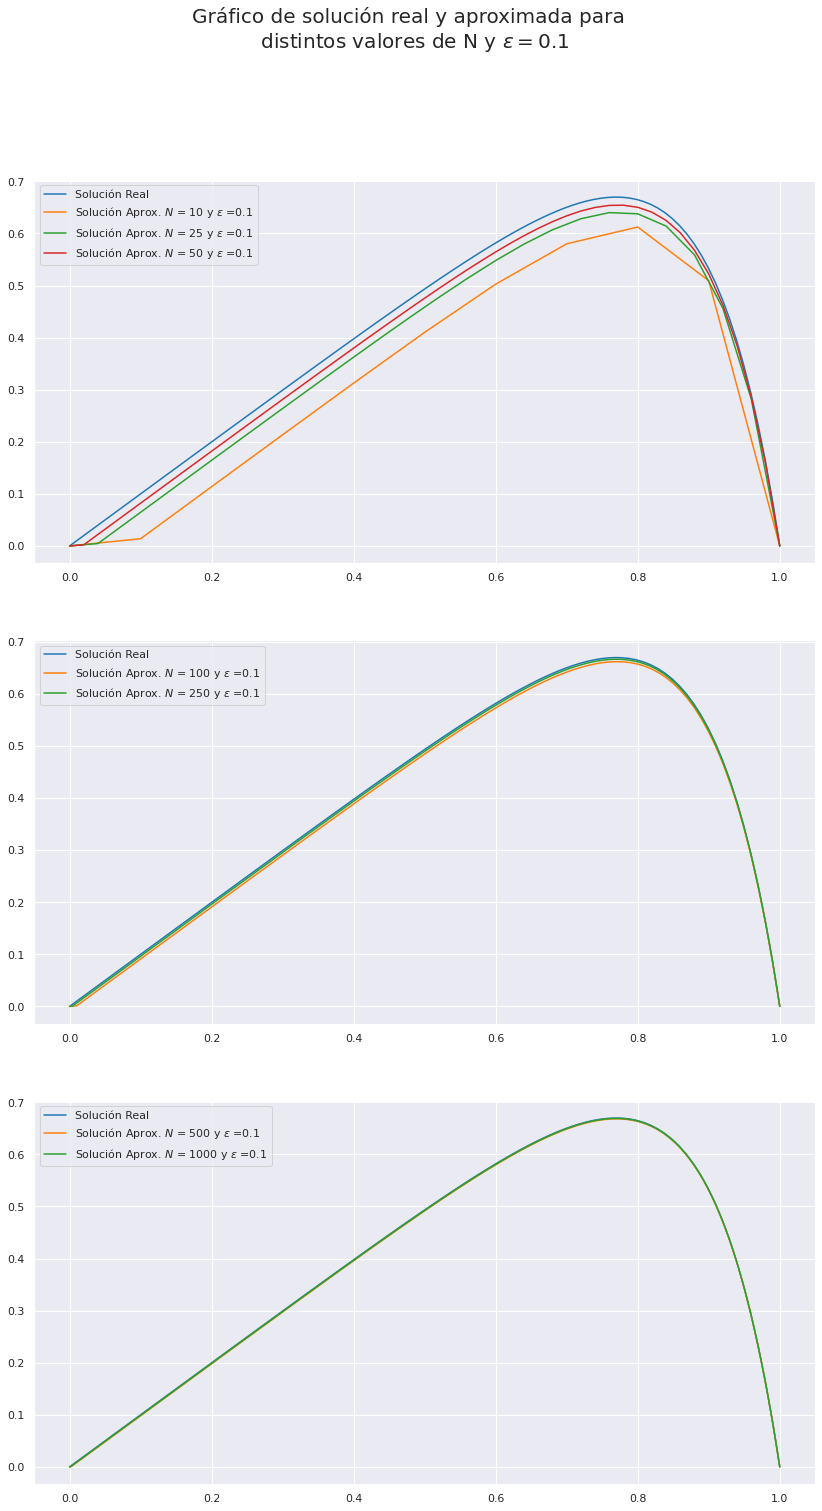

<Figure size 432x288 with 0 Axes>

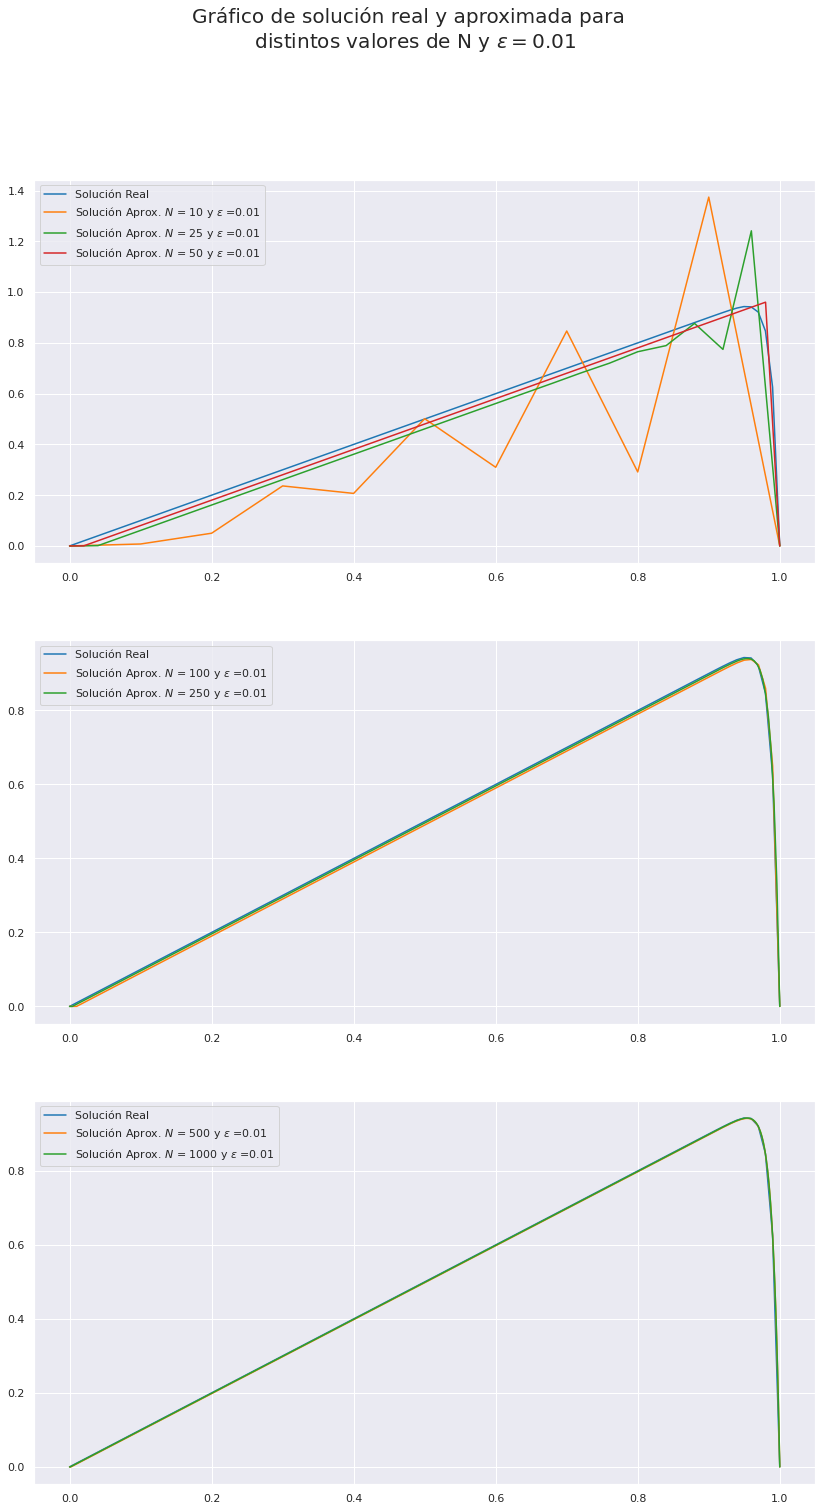

<Figure size 432x288 with 0 Axes>

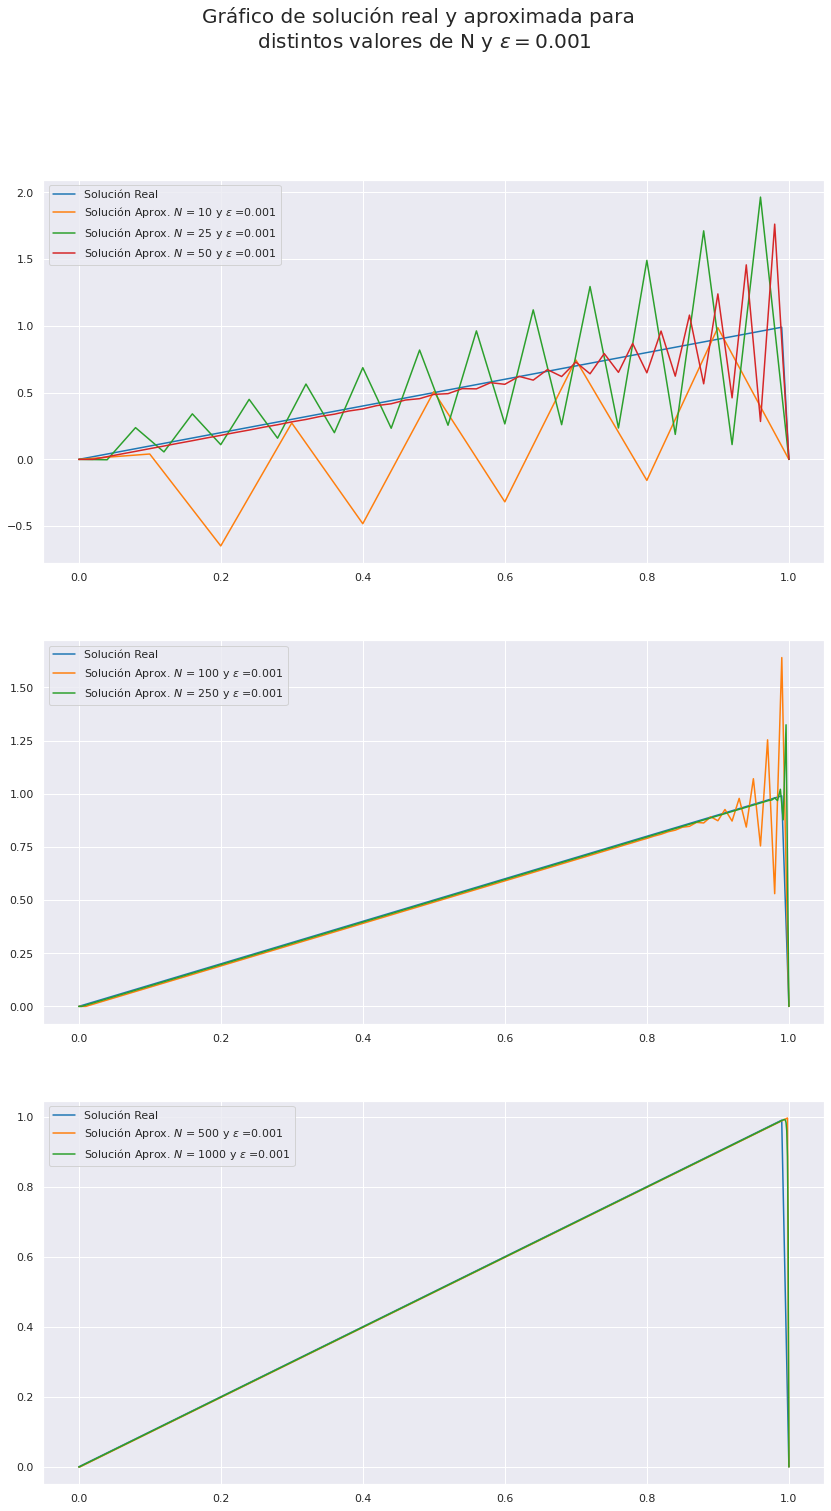

<Figure size 432x288 with 0 Axes>

In [ ]:
N_lista_b       = [10, 25, 50, 100, 250, 500, 1000]
epsilon_lista_b = [10**(-j) for j in [1,2,3]]
for epsilon in epsilon_lista_b:    
    fig, (ax1, ax2, ax3) = plt.subplots(3,figsize = (14,24))
    fig.suptitle(f'Gráfico de solución real y aproximada para \n distintos valores de N y $\epsilon =$'+str(epsilon),fontsize=20)
    ax1.plot(x_2, solucion(x_2,epsilon),label = "Solución Real")
    ax2.plot(x_2, solucion(x_2,epsilon),label = "Solución Real")
    ax3.plot(x_2, solucion(x_2,epsilon),label = "Solución Real")
    for i in range(N):
        if i == 0 or i==1 or i==2:
            N = N_lista_b[i]
            x = np.linspace(0,1,N+1)
            ax1.plot(x, Resuelve(x,ualpha,ubeta,epsilon,a,b,f), 
                        label = f'Solución Aprox. $N$ = '+ str(N)+' y $\epsilon$ =' +str(epsilon))
            ax1.legend()
        if i == 3 or i==4:
            N = N_lista_b[i]
            x = np.linspace(0,1,N+1)
            ax2.plot(x, Resuelve(x,ualpha,ubeta,epsilon,a,b,f), 
                        label = f'Solución Aprox. $N$ = '+ str(N)+' y $\epsilon$ =' +str(epsilon))
            ax2.legend()
        if i == 5 or i==6:
            N = N_lista_b[i]
            x = np.linspace(0,1,N+1)
            ax3.plot(x, Resuelve(x,ualpha,ubeta,epsilon,a,b,f), 
                        label = f'Solución Aprox. $N$ = '+ str(N)+' y $\epsilon$ =' +str(epsilon))
            ax3.legend()
    plt.show()
    plt.clf()

Se observa que mientras más fina es la discretización, el error de la solución aproximada es más pequeño. Esto es una característica en común para todos los métodos de elementos finitos. Además, se puede apreciar  que para epsilon menor entonces, más fina debe ser la discretización del dominio.

##### Estimación del error


**Teorema:** Sean $\alpha,\beta,u_{\alpha},u_{\beta}\in\mathbb{R}$, $\varepsilon>0$,
$\Omega=\left(  \alpha,\beta\right)  $, $a\in W^{1,\infty}\left(
\Omega\right)  $, $b\in L^{\infty}\left(  \Omega\right)  $ y $f\in
L^{2}\left(  \Omega\right)  $. 
Considere $u$ y $u_{h}$ soluciones únicas de (FV) y (FVD), respectivamente. Entonces, existen constantes $C_{0}>0$ y $C_{1}>0$, independientes de $h$, tales que:
$$
\left\Vert u-u_{h}\right\Vert _{0,\Omega}\leq C_{0}h^{2}\hspace{1cm
}\left\vert u-u_{h}\right\vert _{1,\Omega}\leq C_{1}h
$$


Para hacer este cálculo de forma eficiente, se elegirá una regla de cuadratura conveniente. En primer lugar,
$$\left\Vert u-u_{h}\right\Vert _{0,\Omega}^{2}=\sum_{j=1}^{N}\int_{T_{j}%
}\left(  u\left(  x\right)  -u_{h}\right)  ^{2}\text{ }dx
$$
donde $u_{h}$ es de grado a lo más $1$. Aplicando la regla de Simpson, se
tiene que:
$$
\left\Vert u-u_{h}\right\Vert _{0,\Omega}^{2}=\sum_{j=1}^{N}\dfrac{h_{j}}{6}\left[  \left(  u\left(  x_{j}\right)  -u_{j}^{h}\right)  ^{2}+4\left(
u\left(  \bar{x}_{j}\right)  -\dfrac{u_{j}^{h}+u_{j}^{h}}{2}\right)
^{2}+\left(  u\left(  x_{j+1}\right)  -u_{j+1}^{h}\right)  ^{2}\right]
+\mathcal{O}\left(  h_{j}^{5}\right)
$$
Luego, repitiendo el mismo análisis, se tiene que:
$$
\left\vert u-u_{h}\right\vert _{1,\Omega}^{2}=\sum_{j=1}^{N}\int_{T_{j}%
}\left(  u^{\prime}\left(  x\right)  -u_{h}^{\prime}\right)  ^{2}\text{ }dx
$$
donde $u_{h}^{\prime}$ es una función constante a trozos. Entonces, aplicando
la regla del punto medio, se cumple que:
$$
\left\vert u-u_{h}\right\vert _{1,\Omega}^{2}=\sum_{j=1}^{N}h_{j}\left(
u^{\prime}\left(  \bar{x}_{j}\right)  -\dfrac{u_{j+1}-u_{j}}{h_{j}}\right)
^{2}+\mathcal{O}\left(  h_{j}^{3}\right)
$$




c. Considere ahora $\varepsilon = 0.01$ y una discretización uniforme con $N \in \{5, 10, 20, 40, 80, 160, 320, 640, 1280\}$ elementos (es decir, $h_j = h = \frac{1}{N}$). Estime el error en las normas $L^2(\Omega)$, $H^1(\Omega)$ y en la seminorma de $H^1(\Omega)$, grafíquelos y tabúlelos en función de $h$. Para ello, cree una función que permita obtener esos errores. Dicha función debe tener como entradas la discretización del dominio, el vector solución del primer ejercicio, la solución real y su derivada. Las salidas deben ser las normas del error en los espacios $L^2(\Omega)$ y $H^1(\Omega)$, y la seminorma del error en el espacio $H^1(\Omega)$. 

Comente sus resultados.
    
**Indicación:** Puede ser útil usar escala logarítmica para la gráfica de errores. Asimismo, puede resultar útil usar curvas de la forma $Ch$ o $Ch^2$ para comparar las curvas de error con sus respectivos ordenes de convergencia.

In [ ]:
def calcular_errores( Ns,real,derivada):
  erroresL2=[]
  erroresseminorma=[]
  erroresH1=[]
  for N in Ns:
    x=np.array([1/n for n in range(1,N+1)])
    sol=Resuelve(x,0,0,0.01,1,0,lambda x:1)
    errorL2=0
    errorseminorma=0
    for j in range(N-1):
      errorL2+=(real(x[j])-sol[j])**2 + 4*(real((x[j] + x[j+1])/2) - (sol[j+1]+sol[j])/2)**2 + (real(x[j+1]-sol[j+1]))**2
      errorseminorma+= 1/N*(derivada((x[j] + x[j+1])/2) - (real(x[j+1]) - sol[j])*N)**2
    errorL2=errorL2/(6*N)
    errorseminorma=errorseminorma/N
    errorH1= errorseminorma+errorL2
    erroresL2.append(errorL2)
    erroresseminorma.append(errorseminorma)
    erroresH1.append(errorH1)
  error=[erroresL2,erroresseminorma,erroresH1]
  hs=[1/N for N in Ns]
  """Calcula el error de la solucion al problema (1) para una lista de valores de N"""
  return hs, error


In [ ]:
epsilon=0.01
real= lambda x:x-(np.e**((x-1)/epsilon)-np.e**(-1/epsilon))/(1-np.e**(-1/epsilon))
derivada=lambda x:1- np.e**((x-1)/epsilon)*100/((1-np.e**(-1/epsilon)))
def tabulador( Ns,real,derivada):
  errorH1=calcular_errores(Ns,real,derivada)[1][2]
  errorL2= calcular_errores(Ns,real,derivada)[1][0]
  errorseminorma=calcular_errores(Ns,real,derivada)[1][1]
  plt.figure(6)
  plt.figure(figsize = (16,9))
  plt.grid(True)
  plt.title("Error en H1 según taamaño de la malla")
  plt.plot(Ns,errorH1)
  plt.figure(7)
  plt.figure(figsize = (16,9))
  plt.grid(True)
  plt.title("Error en L2 según taamaño de la malla")
  plt.plot(Ns,errorL2)
  plt.figure(8)
  plt.figure(figsize = (16,9))
  plt.grid(True)
  plt.title("Error en seminorma según taamaño de la malla")
  plt.plot(Ns,errorseminorma)
  plt.show

<Figure size 432x288 with 0 Axes>

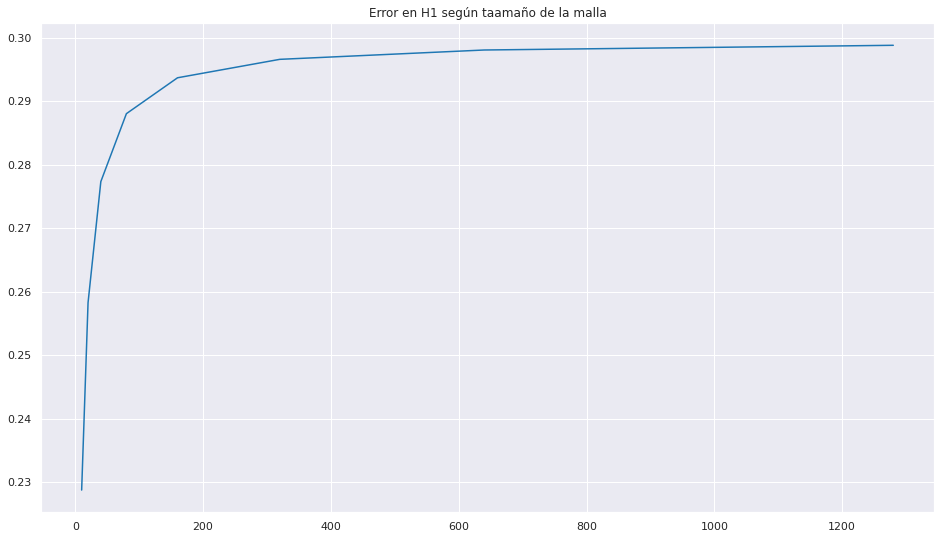

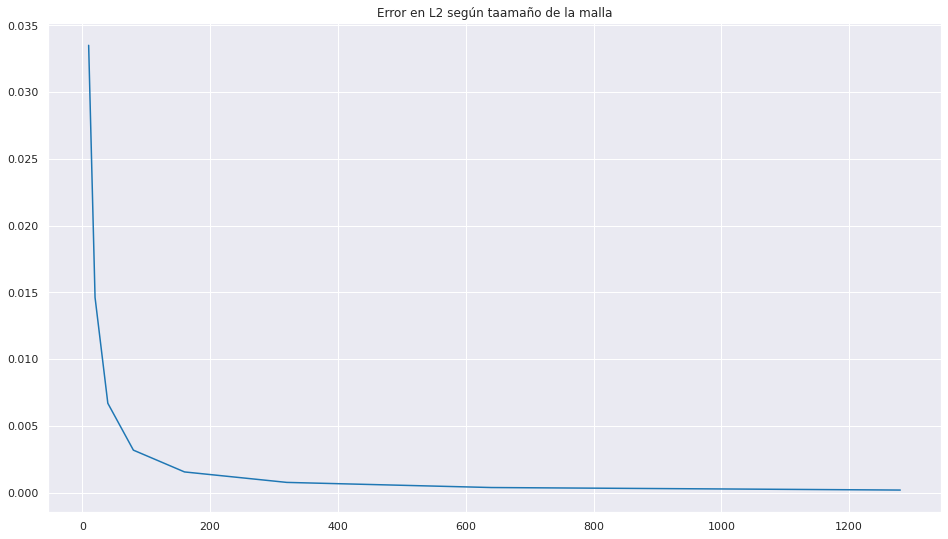

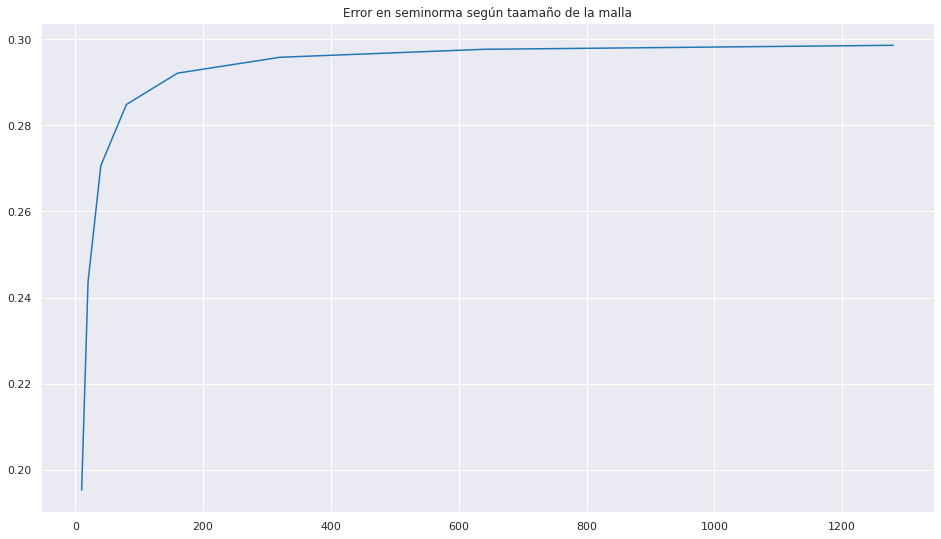

In [ ]:
Ns=[10,20,40,80,160,320,640,1280]
tabulador(Ns,real,derivada)

Podemos observar que la solución converge para todo el tipo de error utlizado, esto es consistente con la representación grafica de la solución ya que sus grafos son muy cercanos cuando N crece. Además se observa que la derivada converge más rapido a la derivada real que el valor de la solución converge al valor real. Otra observación es que mientras más fina es la malla, menor efecto tendrá agregarle un valor constante de celdas extra a la discretización.

### **Ejercicio 3:** 
Considere $f\equiv1$, $a=0$, $b=1$ y $\Omega=\left(  0,1\right)  $.

Para $u_{\alpha}=1, u_{\beta}=0$, la solución analítica de $\textbf{(P)}$ es única e igual a la
función
$$
u(x)=1-\dfrac
{\sinh\left(\varepsilon^{\frac{-1}{2}}x\right)  }{\sinh\left(\varepsilon^{\frac{-1}{2}}\right)}\hspace{1cm} \forall x\in\left[  0,1\right] 
$$

a. Para una discretización uniforme con $N \in \{5, 10, 20, 40, 80\}$ elementos (es decir, $h_j = h = \frac{1}{N+1}$), calcule la solución numérica cuando $\varepsilon = 1$. Grafique todas las soluciones numéricas y la solución analítica (esta última discretizada en una gran cantidad de puntos equiespaciados) en una misma gráfica. Comente sus observaciones.

In [ ]:
#Parametros
f=lambda x:1
a=0
b=1
ualpha=1
ubeta=0
def solucion2(x,epsilon):
    """
    -Input:
    -Output:
    -Descripcion:
    """
    d=epsilon**(-0.5)
    a= np.sinh(d)
    b=np.sinh(d*x)
    output =1 -(b/a)
    return output 

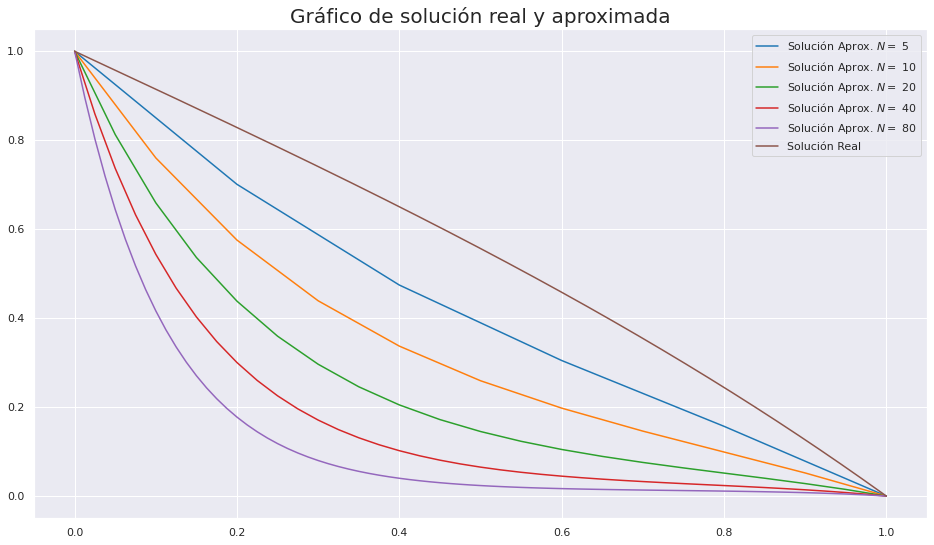

In [ ]:
N_lista = [5, 10, 20,40,80]
epsilon = 1
x_2     = np.linspace(0,1,1000)
# Plotear para cada N en el arreglo N_lista
plt.figure(figsize = (16,9))
plt.grid(True)
for N in N_lista:
    x = np.linspace(0,1,N+1)
    plt.plot(x, Resuelve(x,ualpha,ubeta,epsilon,a,b,f), 
             label = f'Solución Aprox. $N =$ '+ str(N))
plt.plot(x_2, solucion2(x_2,epsilon),label = "Solución Real")
plt.title(f'Gráfico de solución real y aproximada',fontsize=20)
plt.legend()
plt.show()

En este grafico, se puede apreciar que la solución se aleja del valor real mientras N crece. Esto da indicios que este método no es adecuado para este tipo de condiciones ya que la solución práctica esta convergiendo a una función alejada del valor real

b. Repita lo anterior para $\varepsilon = 10^{−j}$ , con $j \in \{1, 2, 3\}$ y $N \in \{10, 25, 50, 100, 250, 500, 1000\}$. Gráfique los tres primeros valores de $N$ en una figura, los dos siguientes en una distinta y los últimos dos en otra. 
    
    Comente sus observaciones.

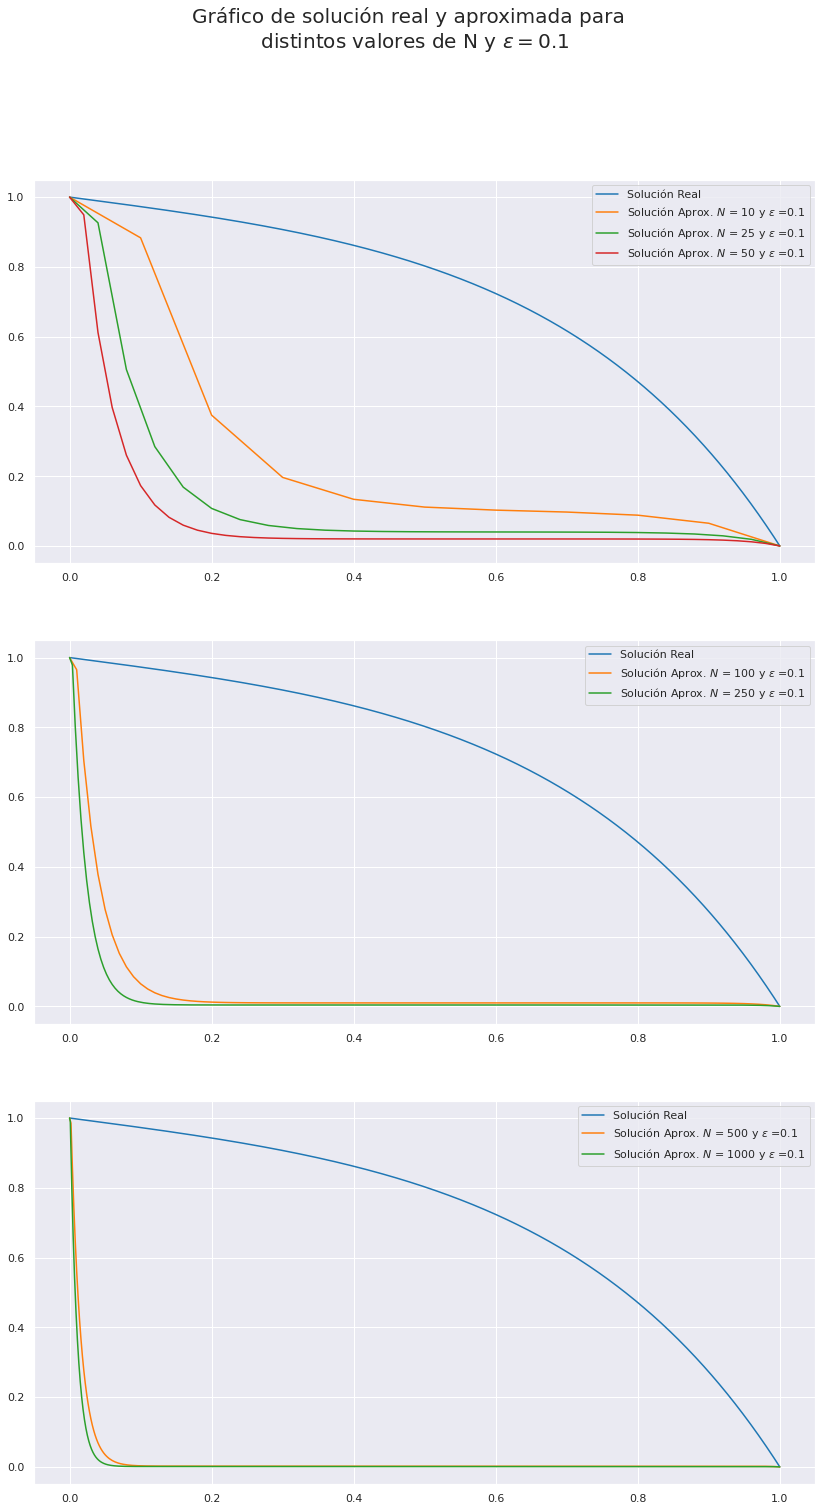

<Figure size 432x288 with 0 Axes>

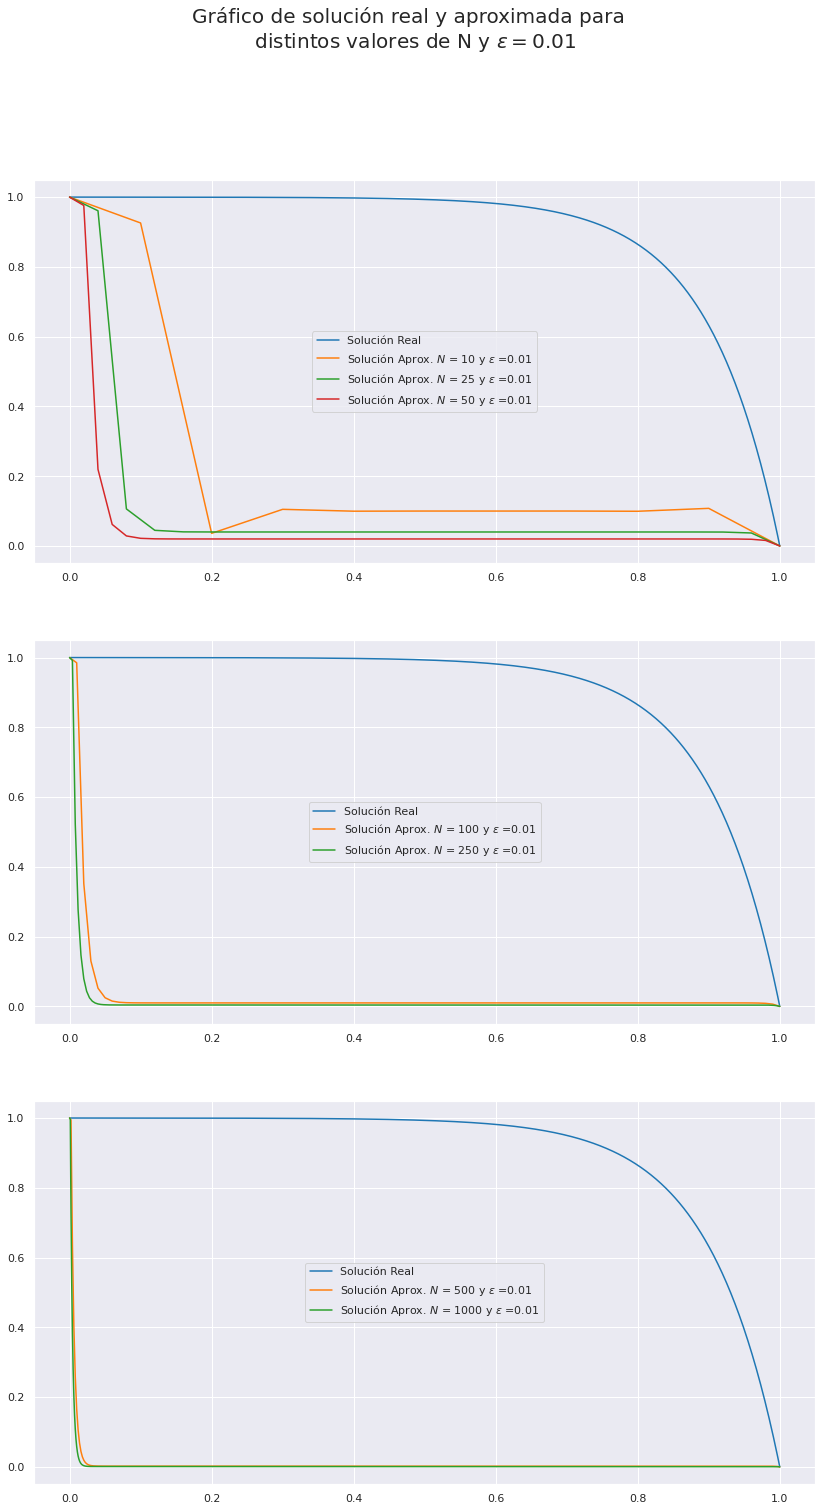

<Figure size 432x288 with 0 Axes>

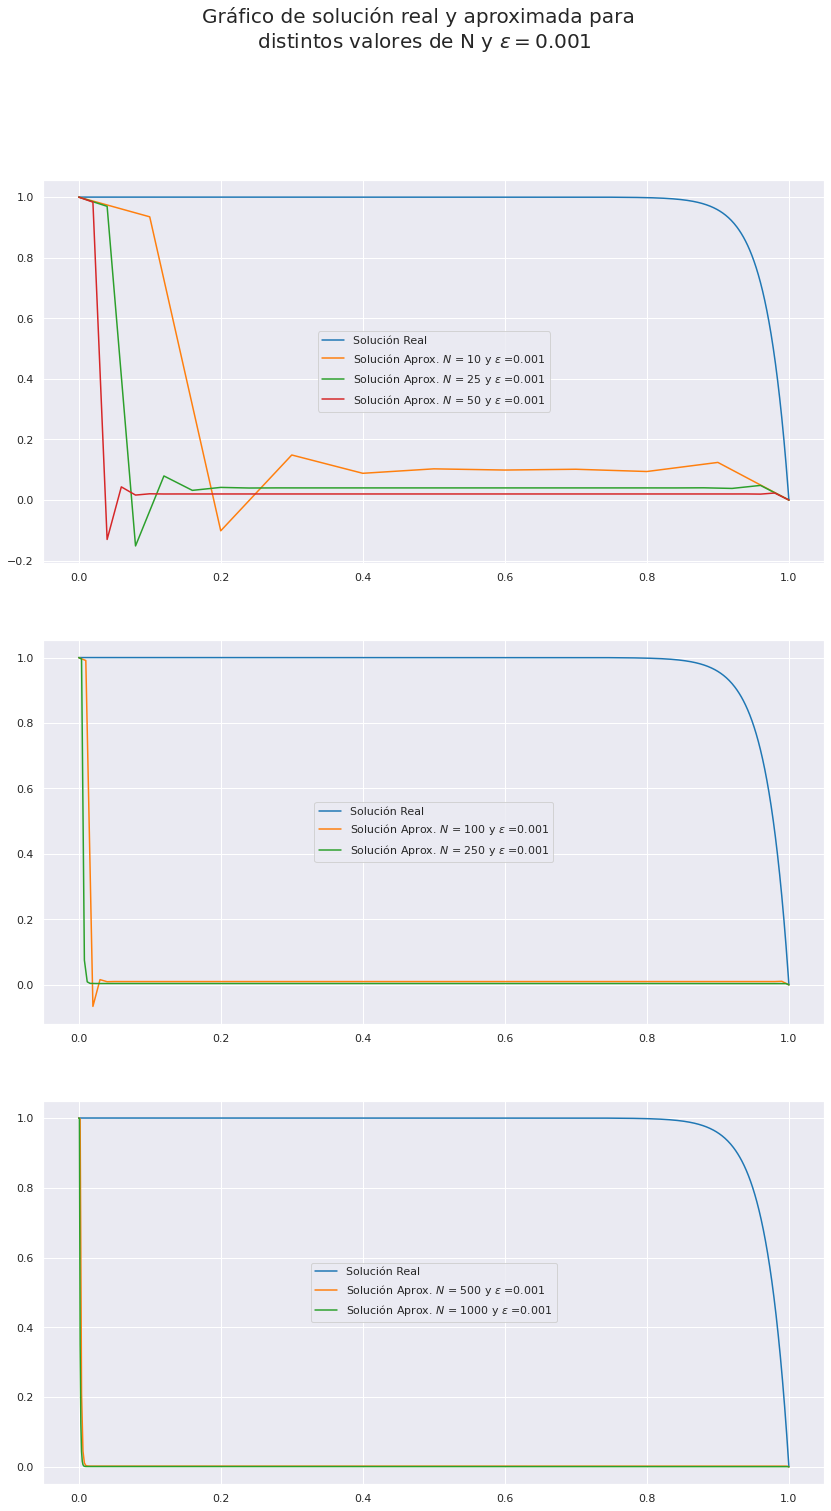

<Figure size 432x288 with 0 Axes>

In [ ]:
N_lista_b       = [10, 25, 50, 100, 250, 500, 1000]
epsilon_lista_b = [10**(-j) for j in [1,2,3]]
for epsilon in epsilon_lista_b:    
    fig, (ax1, ax2, ax3) = plt.subplots(3,figsize = (14,24))
    fig.suptitle(f'Gráfico de solución real y aproximada para \n distintos valores de N y $\epsilon =$'+str(epsilon),fontsize=20)
    ax1.plot(x_2, solucion2(x_2,epsilon),label = "Solución Real")
    ax2.plot(x_2, solucion2(x_2,epsilon),label = "Solución Real")
    ax3.plot(x_2, solucion2(x_2,epsilon),label = "Solución Real")
    for i in range(N):
        if i == 0 or i==1 or i==2:
            N = N_lista_b[i]
            x = np.linspace(0,1,N+1)
            ax1.plot(x, Resuelve(x,ualpha,ubeta,epsilon,a,b,f), 
                        label = f'Solución Aprox. $N$ = '+ str(N)+' y $\epsilon$ =' +str(epsilon))
            ax1.legend()
        if i == 3 or i==4:
            N = N_lista_b[i]
            x = np.linspace(0,1,N+1)
            ax2.plot(x, Resuelve(x,ualpha,ubeta,epsilon,a,b,f), 
                        label = f'Solución Aprox. $N$ = '+ str(N)+' y $\epsilon$ =' +str(epsilon))
            ax2.legend()
        if i == 5 or i==6:
            N = N_lista_b[i]
            x = np.linspace(0,1,N+1)
            ax3.plot(x, Resuelve(x,ualpha,ubeta,epsilon,a,b,f), 
                        label = f'Solución Aprox. $N$ = '+ str(N)+' y $\epsilon$ =' +str(epsilon))
            ax3.legend()
    plt.show()
    plt.clf()


Estos graficos mantinene el comportamiento observado para epsilon igual a 1, se distingue que la solución no converge a la real. Sin embargo, cuando crece epsilon, la solución se va asimilando al reflejo de la solución real bajo cierto eje de simetría lo cual podría significar que el método funciona y existe un error de implementación o que existe una convergencia a otra función relacionada con la solución real





c. Considere ahora $\varepsilon = 10^{-4}$ y una discretización uniforme con $N \in \{5, 10, 20, 40, 80, 160, 320, 640, 1280\}$ elementos (es decir, $h_j = h = \frac{1}{N+1}$). Estime el error en las normas $L^2(\Omega)$, $H^1(\Omega)$ y en la seminorma de $H^1(\Omega)$, grafíquelos y tabúlelos en función de $h$. Para ello, cree una función que permita obtener esos errores. Dicha función debe tener como entradas la discretización del dominio, el vector solución del primer ejercicio, la solución real y su derivada. Las salidas deben ser las normas del error en los espacios $L^2(\Omega)$ y $H^1(\Omega)$, y la seminorma del error en el espacio $H^1(\Omega)$. 

    Comente sus resultados.
    
    **Indicación:** Puede ser útil usar escala logarítmica para la gráfica de errores. Asimismo, puede resultar útil usar curvas de la forma $Ch$ o $Ch^2$ para comparar las curvas de error con sus respectivos ordenes de convergencia.

In [ ]:
def calcular_errores( Ns,real,derivada):
  erroresL2=[]
  erroresseminorma=[]
  erroresH1=[]
  for N in Ns:
    x=np.array([1/n for n in range(1,N+1)])
    sol=Resuelve(x,1,0,10**-4,0,1,lambda x:1)
    errorL2=0
    errorseminorma=0
    for j in range(N-1):
      errorL2+=(real(x[j])-sol[j])**2 + 4*(real((x[j] + x[j+1])/2) - (sol[j+1]+sol[j])/2)**2 + (real(x[j+1]-sol[j+1]))**2
      errorseminorma+= 1/N*(derivada((x[j] + x[j+1])/2) - (real(x[j+1]) - sol[j])*N)**2
    errorL2=np.log(errorL2/(6*N))
    errorseminorma=np.log(errorseminorma/N)
    errorH1= (errorseminorma+errorL2)
    erroresL2.append(errorL2)
    erroresseminorma.append(errorseminorma)
    erroresH1.append(errorH1)
  error=[erroresL2,erroresseminorma,erroresH1]
  hs=[1/N for N in Ns]
    


  """Calcula el error de la solucion al problema (1) para una lista de valores de N"""
   
  return hs, error


In [ ]:
def tabulador( Ns,real,derivada):
  errorH1=calcular_errores(Ns,real,derivada)[1][2]
  errorL2= calcular_errores(Ns,real,derivada)[1][0]
  errorseminorma=calcular_errores(Ns,real,derivada)[1][1]
  plt.figure(0)
  plt.title("Error en H1 según tamaño de la malla")
  plt.plot(Ns,errorH1)
  plt.show
  plt.figure(1)
  plt.title("Error en L2 según tamaño de la malla")
  plt.plot(Ns,errorL2)
  plt.show
  plt.figure(2)
  plt.title("Error en seminorma según taamaño de la malla")
  plt.plot(Ns,errorseminorma)
  plt.show

In [ ]:
real= lambda x: 1- (np.sinh(x*10**2)/np.sinh(10**2))
derivada= lambda x: np.cosh(10**2)*100/(np.sinh(100))
Ns=[5,10,20,40,80,160,320,640,1280]
tabulador(Ns,real,derivada)

Analizando los graficos de errores, se puede ver que la elección de método para calcular el error es importante ya que debido a la baja norma de la solución, segun el error en L2, la solución esta convergiendo. Sin embargo, al tomar en cuenta la derivada se puede evidenciar que la solución no converge a la real sino que ambas se anulan a partir de cierto momento.